# Deep Convolutional GAN (DCGAN)

### 목표
이 노트북에서는 MNIST 데이터 세트를 사용하여 또 다른 GAN을 생성합니다. 2015 년에 개발 된 매우 성공적이고 영향력있는 GAN 모델 인 Deep Convolutional GAN (DCGAN)을 구현합니다.

*참고 : 관심이 있다면 [여기](https://arxiv.org/pdf/1511.06434v1.pdf)가 논문입니다. 지금은 이해하기 힘들어 보일지 모르지만 곧 여러분은 그것의 많은 부분을 이해할 수 있을 것입니다. :)*

### 학습 목표
1. 널리 사용되는 GAN:DCGAN (Deep Convolutional GAN)을 만드는 실습 경험을 얻으십시오.
2. 강력한 생성 모델을 훈련시킵니다.

![Generator architecture](dcgan-gen.png)

그림 : [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf)에서 DCGAN의 생성기 아키텍처 도면.

## 시작하기

#### DCGAN
다음은 DCGAN의 주요 특징들입니다 (이를 외우는 것에 대해 걱정하지 마십시오. 구현 과정을 안내 받을 것입니다!) :

* 풀링 레이어 없이 컨볼루션 사용
* 생성기와 판별기 모두에서 batchnorm 사용
* 완전히 연결된 숨겨진 레이어를 사용하지 마십시오
* Tanh 활성화를 사용하는 출력을 제외한 모든 계층에 대해 생성기에서 ReLU 활성화를 사용합니다.
* 활성화를 사용하지 않는 출력을 제외한 모든 계층에 대해 판별기에서 LeakyReLU 활성화 사용

GAN을 만드는 데 도움이 되는 유용한 패키지와 데이터를 가져 오는 것으로 시작합니다. GAN이 생성할 이미지를 볼 수 있도록 시각화 도우미 함수도 제공됩니다.

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## 생성기

당신이 만들 첫 번째 구성 요소는 생성기입니다. 이미지 차원을 전달하는 대신 이미지 채널 수를 생성기에 전달한다는 것을 알 수 있습니다. DCGAN에서는 이미지의 픽셀 수에 의존하지 않는 컨볼루션을 사용하기 때문입니다. 그러나 채널 수는 필터의 크기를 결정하는 데 중요합니다.

4 개의 레이어 (히든 레이어 3 개 + 출력 레이어 1 개)를 사용하여 생성기를 구축합니다. 이전과 마찬가지로 생성기의 신경망을 위한 단일 블록을 생성하는 함수를 작성해야합니다.

DCGAN에서 활성화 함수는 출력 레이어에 따라 다르기 때문에 어떤 레이어가 생성되는지 확인해야 합니다. 코드 셀 다음에 몇 가지 테스트가 제공되므로 올바른 길을 가고 있는지 확인할 수 있습니다!

생성기 클래스가 끝나면 노이즈 벡터를 받아 신경망을 사용하여 출력 차원의 이미지를 생성하는 순방향 통과 함수가 제공됩니다. 노이즈 벡터를 생성하는 함수도 제공됩니다. 이 기능은 마지막 과제의 기능과 동일합니다.


<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

생성기 블록에 대한 테스트는 다음과 같습니다.:

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## 판별기

생성해야하는 두 번째 구성 요소는 판별기입니다.

판별기의 신경망에서 3 개의 레이어를 사용합니다. 생성기와 마찬가지로 판별기에 대한 단일 신경망 블록을 생성하는 함수를 생성해야 합니다.

마지막에 사용할 테스트도 있습니다.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

In [5]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Here's a test for your discriminator block:

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## 훈련
이제 모든 것을 합칠 수 있습니다!
매개 변수는 다음과 같습니다.
* criterion : 손실 함수
* n_epochs : 훈련 할 때 전체 데이터 세트를 반복하는 횟수
* z_dim : 노이즈 벡터의 차원
* display_step : 이미지를 표시/시각화하는 빈도
* batch_size : 순방향/역방향 패스 당 이미지 수
* lr : 학습률
* beta_1, beta_2 : 모멘텀 항
* device : 장치 유형
<!-- 또한 ** 기본 CPU에서 매우 느리게 실행됩니다 **. 이를 더 빨리 실행하는 한 가지 방법은 .ipynb를 다운로드하여 Google 드라이브에 업로드 한 다음 Google Colab에서 열고 '런타임-> 런타임 유형 변경'을 클릭 한 다음 하드웨어 가속기를 GPU로 설정하고 교체하는 것입니다.
`device = "cpu"`
를 
`device = "cuda"` 로. 그런 다음 코드를 더 이상 변경하지 않고 1,000 배 이상 빠르게 실행해야합니다.  -->

In [9]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999

# device = 'cuda'
device = 'cpu'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation) 
# For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, 
# the maximum value of 1 will be converted to (1-0.5)/0.5=1.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw




Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Processing...


D:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


그런 다음 생성기, 판별기 및 최적화 프로그램을 초기화 할 수 있습니다.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

마지막으로 GAN을 훈련시킬 수 있습니다!
각 세대에 대해 전체 데이터 세트를 일괄 처리합니다. 모든 배치에 대해 판별 자와 생성기를 업데이트합니다. 그러면 DCGAN의 결과를 볼 수 있습니다!

예상해야 할 대략적인 진행 상황은 다음과 같습니다. GPU에서는 천 단계 당 약 30 초가 걸립니다. CPU에서는 천 단계 당 약 8 시간이 걸릴 수 있습니다. 5000 단계의 이미지에서 생성기가 마치 생성기처럼 보이는 것을 불충분하게 생성하고 있음을 알 수 있습니다. 판별자가이 불균형을 충분히 빠르게 감지하는 방법을 배우지 못하면 생성기는 더 많은 불균형을 생성 할 수 있습니다. 결과적으로 모드 붕괴로 알려진 더 이상 개선이 없을 정도로 판별자를 속이는 결과가 나왔을 수 있습니다:
![MNIST Digits Progression](MNIST_DCGAN_Progression.png)

Step 500: Generator loss: 0.8317842628955844, discriminator loss: 0.593339612007141


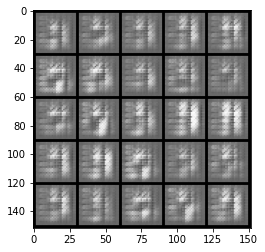

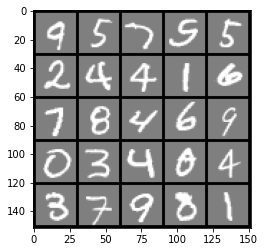

Step 1000: Generator loss: 0.9065862823724751, discriminator loss: 0.6099744473695755


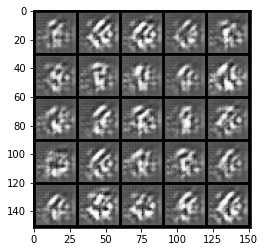

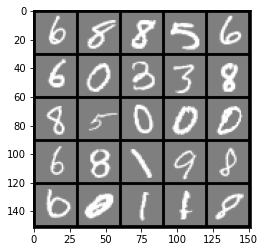

Step 1500: Generator loss: 0.8244500271081926, discriminator loss: 0.6302340140342706


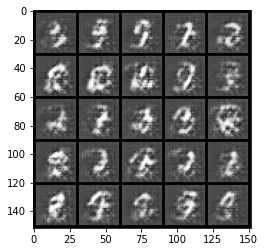

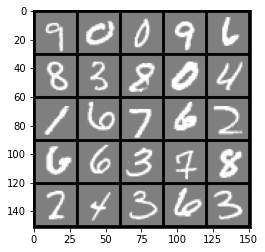

Step 2000: Generator loss: 0.8436608763933188, discriminator loss: 0.6058888806104662


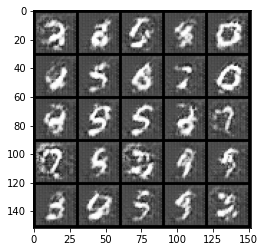

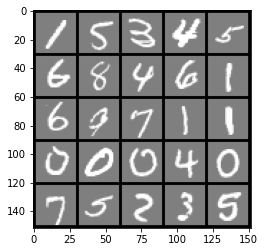

Step 2500: Generator loss: 0.8482516487836841, discriminator loss: 0.6060605964660648


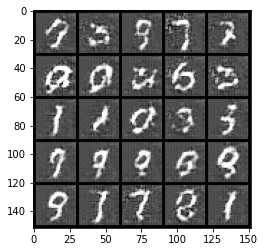

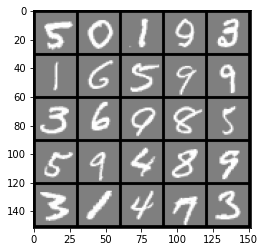

Step 3000: Generator loss: 0.8218995717763911, discriminator loss: 0.6259041153192523


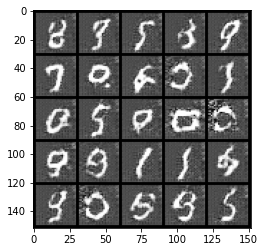

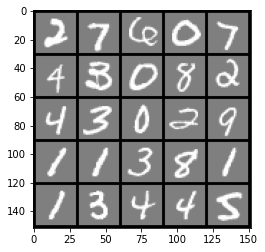

Step 3500: Generator loss: 0.8616744799017909, discriminator loss: 0.6262909530401227


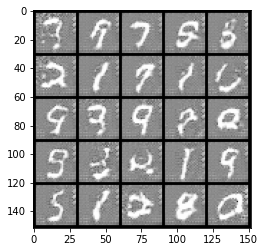

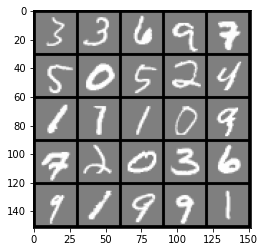

Step 4000: Generator loss: 0.7914625313282011, discriminator loss: 0.6421922426223746


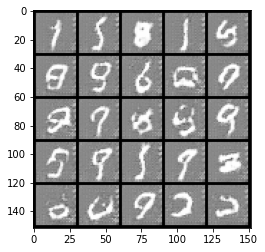

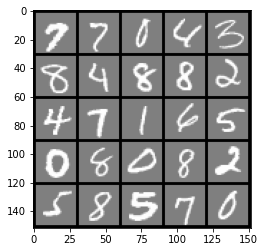

Step 4500: Generator loss: 0.7929397044181825, discriminator loss: 0.6458125458955774


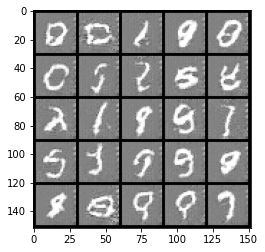

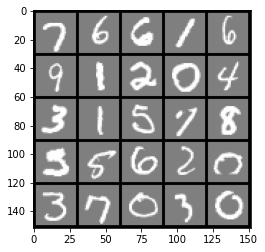

Step 5000: Generator loss: 0.7840008137226099, discriminator loss: 0.6526557315587996


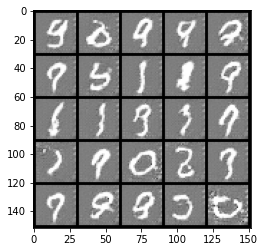

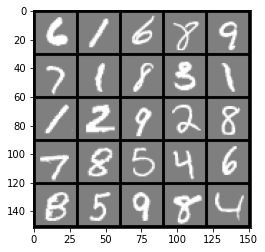

Step 5500: Generator loss: 0.7705038805007937, discriminator loss: 0.6627596746683116


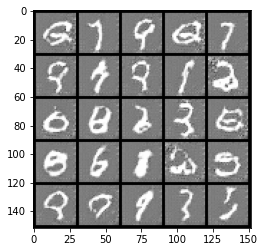

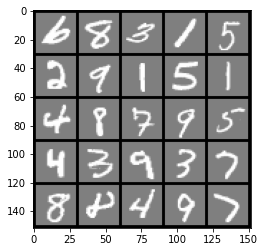

Step 6000: Generator loss: 0.766816015601159, discriminator loss: 0.6640485444068904


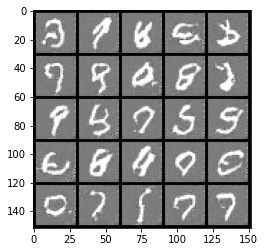

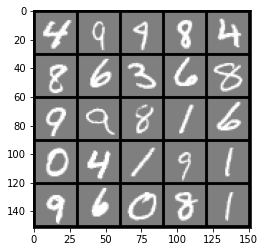

Step 6500: Generator loss: 0.7643620793819426, discriminator loss: 0.6672568608522409


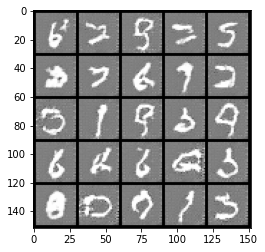

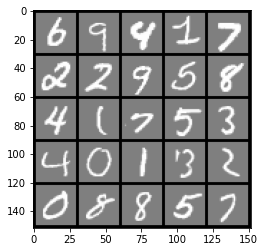

Step 7000: Generator loss: 0.7528418785333632, discriminator loss: 0.6707909194231033


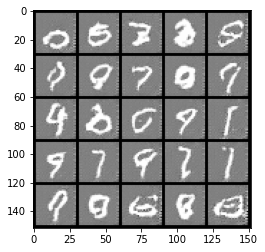

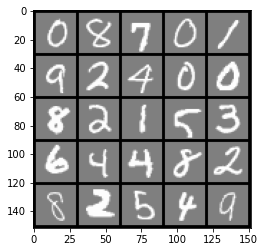

Step 7500: Generator loss: 0.7510253986120233, discriminator loss: 0.6736266344785695


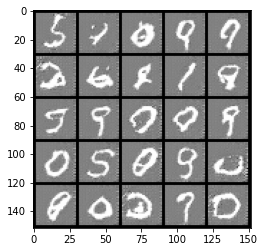

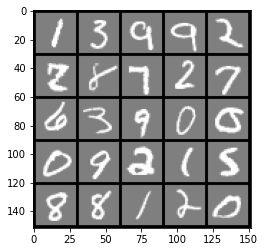

Step 8000: Generator loss: 0.7468870389461526, discriminator loss: 0.677736278772354


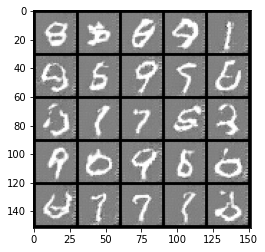

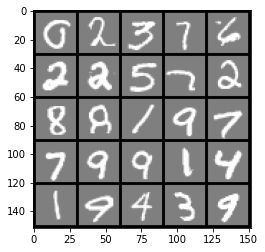

Step 8500: Generator loss: 0.7364195359945301, discriminator loss: 0.6819863890409471


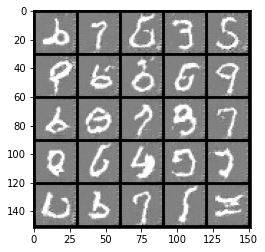

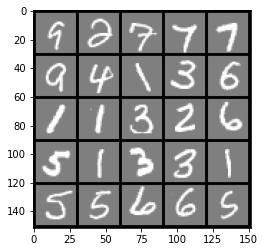

Step 9000: Generator loss: 0.7376747486591341, discriminator loss: 0.6849199386835104


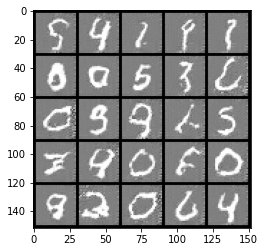

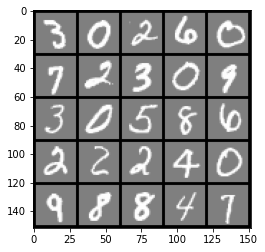

Step 9500: Generator loss: 0.7335894734859474, discriminator loss: 0.6866533570289611


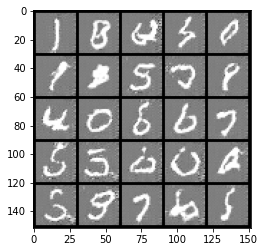

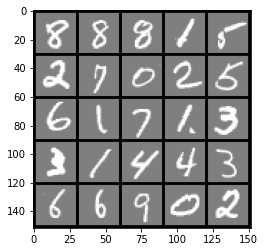

Step 10000: Generator loss: 0.7295183807611464, discriminator loss: 0.6885745135545727


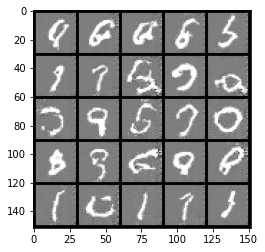

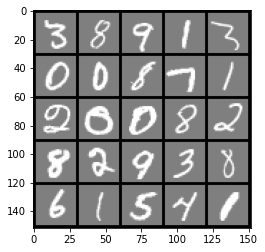

Step 10500: Generator loss: 0.7270010217428198, discriminator loss: 0.6889417169094083


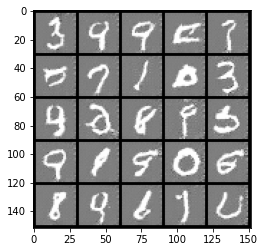

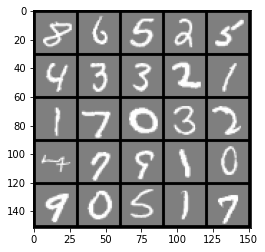

Step 11000: Generator loss: 0.7237582861185072, discriminator loss: 0.6890896979570387


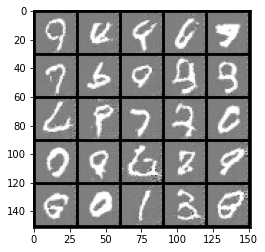

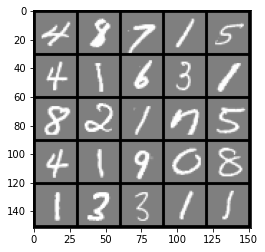

Step 11500: Generator loss: 0.7232239935398104, discriminator loss: 0.6902856024503704


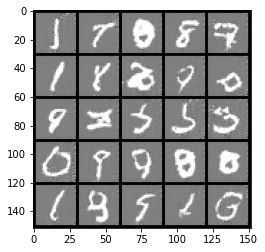

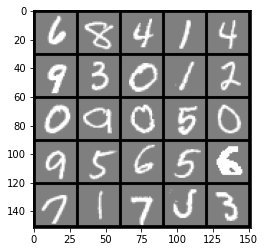

Step 12000: Generator loss: 0.724087451219559, discriminator loss: 0.6910815365314488


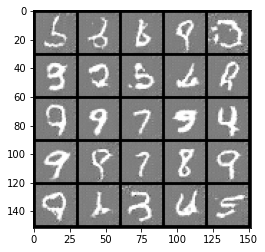

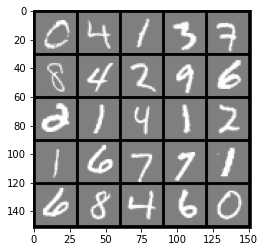

Step 12500: Generator loss: 0.7189068508148186, discriminator loss: 0.6914319450855254


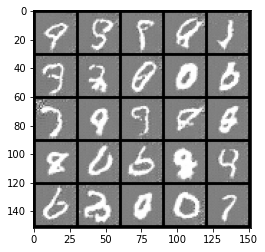

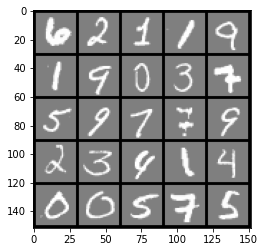

Step 13000: Generator loss: 0.718096009850502, discriminator loss: 0.6924771052598958


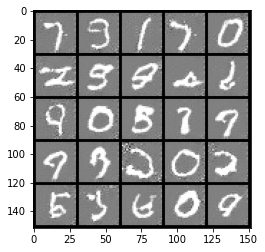

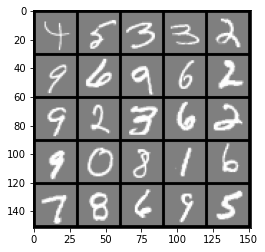

Step 13500: Generator loss: 0.7148481378555297, discriminator loss: 0.6930730757713318


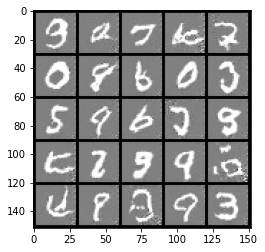

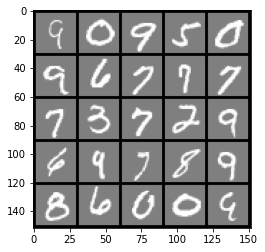

Step 14000: Generator loss: 0.7152018066644672, discriminator loss: 0.6935333331823343


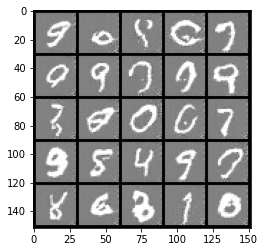

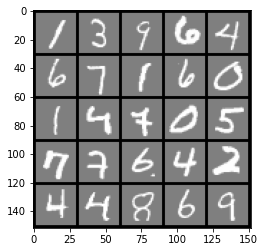

Step 14500: Generator loss: 0.7130994273424153, discriminator loss: 0.6936473597288132


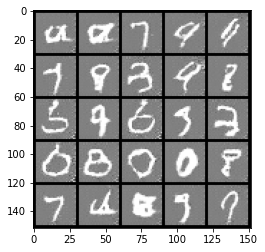

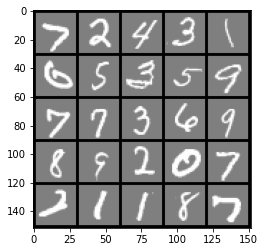

Step 15000: Generator loss: 0.7097009580135335, discriminator loss: 0.6950692703723909


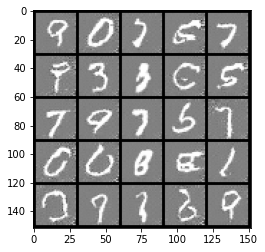

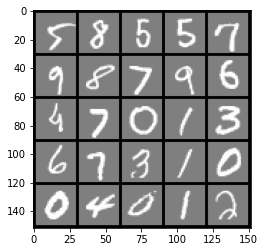

Step 15500: Generator loss: 0.7094756251573561, discriminator loss: 0.6950216300487518


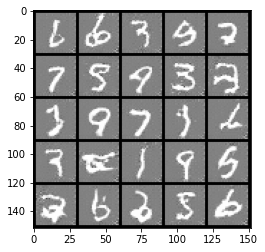

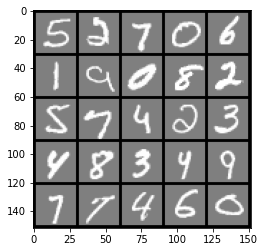

Step 16000: Generator loss: 0.7080472369194031, discriminator loss: 0.6956703755855557


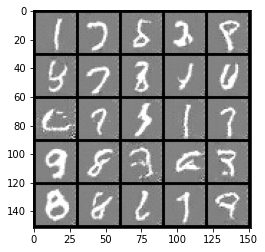

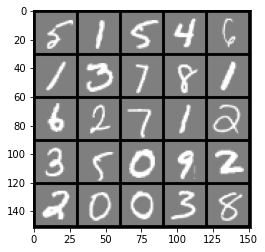

Step 16500: Generator loss: 0.7083077578544618, discriminator loss: 0.6961445338726048


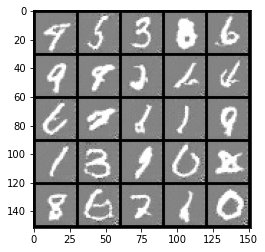

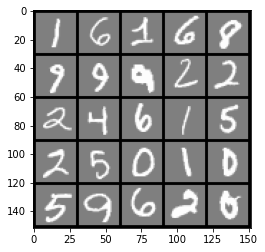

Step 17000: Generator loss: 0.7058882589340216, discriminator loss: 0.6958445495367054


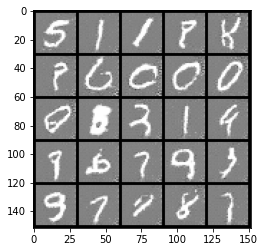

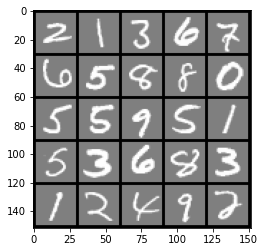

Step 17500: Generator loss: 0.7052044242620465, discriminator loss: 0.6960654771327967


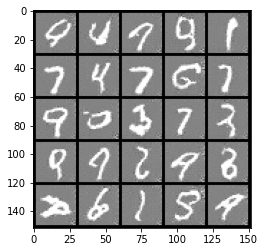

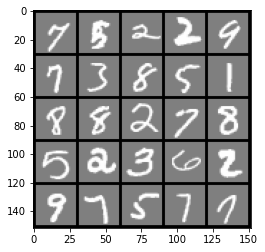

Step 18000: Generator loss: 0.7034636330604548, discriminator loss: 0.6971388503313065


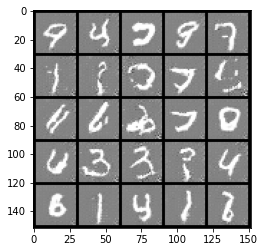

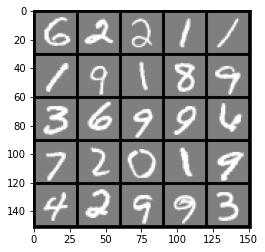

Step 18500: Generator loss: 0.7039956582784651, discriminator loss: 0.6965275226831433


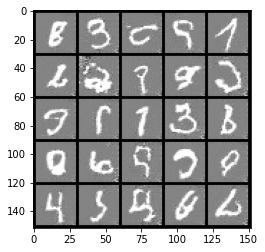

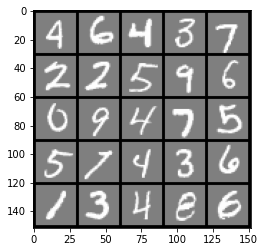

Step 19000: Generator loss: 0.701254457473755, discriminator loss: 0.6964553060531616


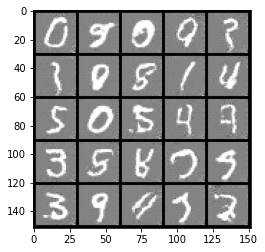

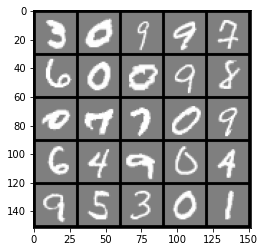

Step 19500: Generator loss: 0.7016977355480195, discriminator loss: 0.6968863404989247


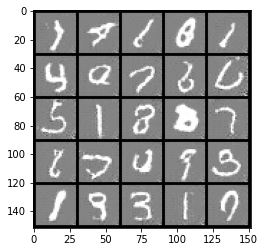

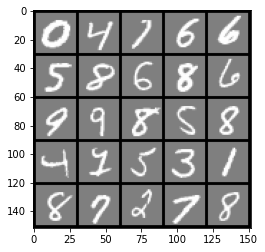

Step 20000: Generator loss: 0.7011969001293179, discriminator loss: 0.6963096085786818


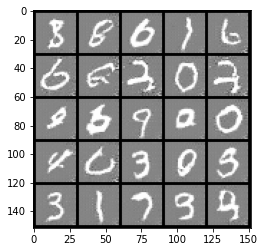

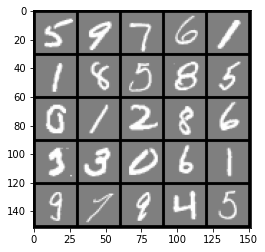

Step 20500: Generator loss: 0.7002055041790004, discriminator loss: 0.6966864476203926


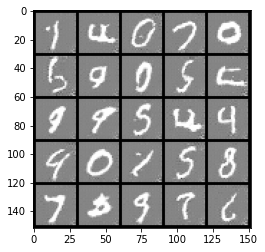

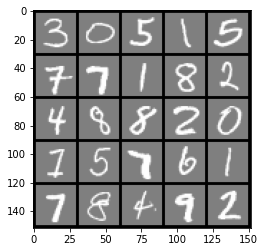

Step 21000: Generator loss: 0.7000262881517412, discriminator loss: 0.696587468743324


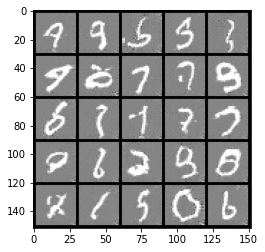

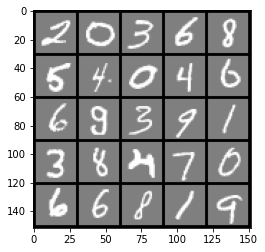

Step 21500: Generator loss: 0.6994959242343911, discriminator loss: 0.6971762288808827


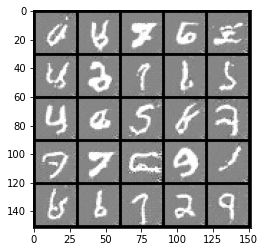

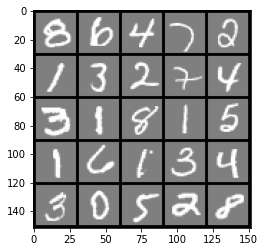

Step 22000: Generator loss: 0.698546325206756, discriminator loss: 0.6970327177047735


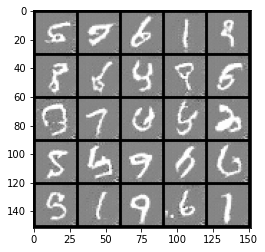

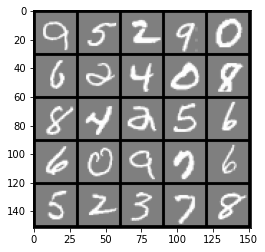

Step 22500: Generator loss: 0.6971701802015304, discriminator loss: 0.6973705508708955


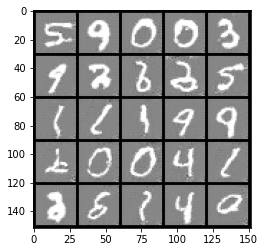

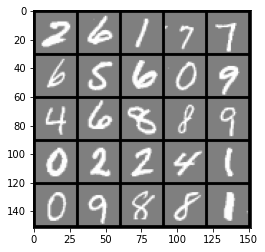

Step 23000: Generator loss: 0.695945588946343, discriminator loss: 0.6972054218053816


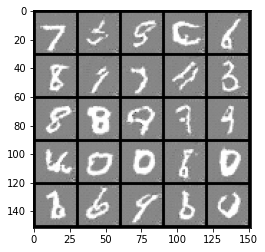

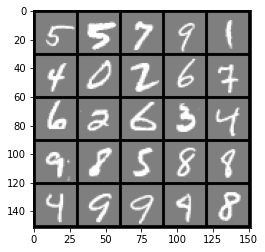

In [11]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
